In [1]:
import pandas as pd
import numpy as np
import string

Using TensorFlow backend.


In [2]:
lines= pd.read_table('C:/Users/ysp/Desktop/Deep Learning/english to french.txt', names=['eng', 'fr'])

In [3]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [4]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [5]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [6]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [7]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [8]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [9]:
lines.shape

(50000, 2)

In [10]:
# fit a tokenizer
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [12]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [13]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [14]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [15]:
filter_eng_words('he is extremely good')

'he is unk good '

In [16]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [17]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [18]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [19]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [20]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [21]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [22]:
len(all_eng_words)

385

In [23]:
len(target_words)

358

In [24]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [25]:
num_decoder_tokens

358

In [26]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [27]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [28]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [29]:
print(eng_max_length)
print(fr_max_length)

8
17


In [30]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [31]:
decoder_target_data.shape

(50000, 17, 359)

In [32]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [33]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [34]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [35]:
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout
model1 = Sequential()
model1.add(Embedding(len(input_words)+1, 128, input_length=eng_max_length))
model1.add(Bidirectional(LSTM(256)))
model1.add(RepeatVector(fr_max_length))
model1.add((LSTM(256, return_sequences=True)))
model1.add((Dense(len(target_token_index)+1, activation='softmax')))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 128)            49408     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               788480    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 17, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 17, 256)           787456    
_________________________________________________________________
dense_1 (Dense)              (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [36]:
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

In [37]:
history = model1.fit(encoder_input_data, decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

C:\Users\ysp\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 67s 1ms/step - loss: 1.1745 - acc: 0.7920 - val_loss: 1.2939 - val_acc: 0.7573
Epoch 2/5
47500/47500 [==============================] - 72s 2ms/step - loss: 0.9148 - acc: 0.8157 - val_loss: 1.1596 - val_acc: 0.7687
Epoch 3/5
47500/47500 [==============================] - 72s 2ms/step - loss: 0.7829 - acc: 0.8345 - val_loss: 1.0377 - val_acc: 0.7824
Epoch 4/5
47500/47500 [==============================] - 73s 2ms/step - loss: 0.6953 - acc: 0.8458 - val_loss: 0.9580 - val_acc: 0.7928
Epoch 5/5
47500/47500 [==============================] - 74s 2ms/step - loss: 0.6331 - acc: 0.8530 - val_loss: 0.8998 - val_acc: 0.7979


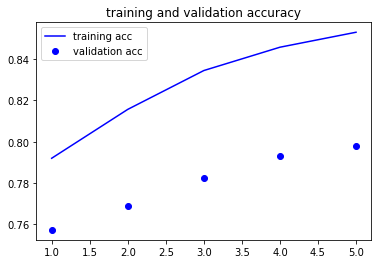

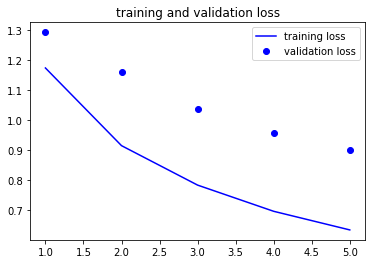

In [38]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()


In [39]:
count = 0
correct_count = 0
pred = model1.predict(encoder_input_data[47500:])
for i in range(2500):
    t = np.argmax(pred[i], axis=-1)
    act=np.argmax(decoder_target_data[47500+i], axis=-1)
    correct_count += np.sum((act==t) & (act!=89))
    count += np.sum(act!=89)
print(correct_count, count)
print(correct_count/count)

5324 13426
0.396544019067481


In [55]:
encoder_input_data[-2400]

array([155.,  98., 185., 336.,   0.,   0.,   0.,   0.], dtype=float32)

In [56]:
t = model1.predict(encoder_input_data[-2400].reshape(1,encoder_input_data.shape[1])).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])


je
me
unk
unk
unk
end
end
end
end
end
end
end
end
end
end
end
end
